# traffic jam classiffier
A statistics approach

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from pyspark.sql import SQLContext
#from pyspark.sql.types import *
#sqlContext = SQLContext(sc)

/Users/multidest/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
rdd = spark.read.load('../five_min_frame.csv', 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

rdd.count()

154289957

In [5]:
rdd.first()

Row(_c0=0, Timestamp=u'01/01/2015 00:00:00', Station=1100313, District=11, Freeway #=5, Direction=u'N', Lane Type=u'FR', Station Length=None, Samples=10, % Observed=100, Total Flow=16.0, Avg Occupancy=None, Avg Speed=None)

In [6]:
rdd.dtypes

[('_c0', 'int'),
 ('Timestamp', 'string'),
 ('Station', 'int'),
 ('District', 'int'),
 ('Freeway #', 'int'),
 ('Direction', 'string'),
 ('Lane Type', 'string'),
 ('Station Length', 'double'),
 ('Samples', 'int'),
 ('% Observed', 'int'),
 ('Total Flow', 'double'),
 ('Avg Occupancy', 'double'),
 ('Avg Speed', 'double')]

In [7]:
#rdd = rdd.filter(rdd.Station==1108291)
rdd = rdd.filter(rdd.Station==1123134)

In [8]:
df = rdd.toPandas()

In [9]:
df.head()

,_c0,Timestamp,Station,District,Freeway #,Direction,Lane Type,Station Length,Samples,% Observed,Total Flow,Avg Occupancy,Avg Speed
0,1369,01/01/2015 00:00:00,1123134,11,5,S,ML,0.49,10,100,0.0,0.0000,65.0
1,2848,01/01/2015 00:05:00,1123134,11,5,S,ML,0.49,10,100,5.0,0.0082,65.0
2,4327,01/01/2015 00:10:00,1123134,11,5,S,ML,0.49,1,100,0.0,0.0000,65.0
3,5806,01/01/2015 00:15:00,1123134,11,5,S,ML,0.49,0,0,5.0,0.0077,64.9
4,7285,01/01/2015 00:20:00,1123134,11,5,S,ML,0.49,5,100,2.0,0.0043,65.0


In [10]:
df.columns = [x.replace(' ','_').lower() for x in df.columns]

In [11]:
df.columns

Index([u'_c0', u'timestamp', u'station', u'district', u'freeway_#',
       u'direction', u'lane_type', u'station_length', u'samples',
       u'%_observed', u'total_flow', u'avg_occupancy', u'avg_speed'],
      dtype='object')

In [12]:
df = df.sort_values('timestamp')
df.loc[:,['total_flow','avg_occupancy','avg_speed']].describe()

,total_flow,avg_occupancy,avg_speed
count,104789.000000,104789.000000,104789.000000
mean,18.633979,0.039988,62.640970
std,16.097937,0.035357,5.958028
min,0.000000,0.000000,4.000000
25%,4.000000,0.009700,62.000000
50%,16.000000,0.035000,64.300000
75%,29.000000,0.062400,65.000000
max,150.000000,0.790300,75.900000


In [13]:
fsp = df.loc[:,['total_flow','avg_occupancy','avg_speed']]
normalized_fsp=(fsp-fsp.min())/(fsp.max()-fsp.min())
standardized_fsp=(fsp-fsp.mean())/fsp.std()

[]

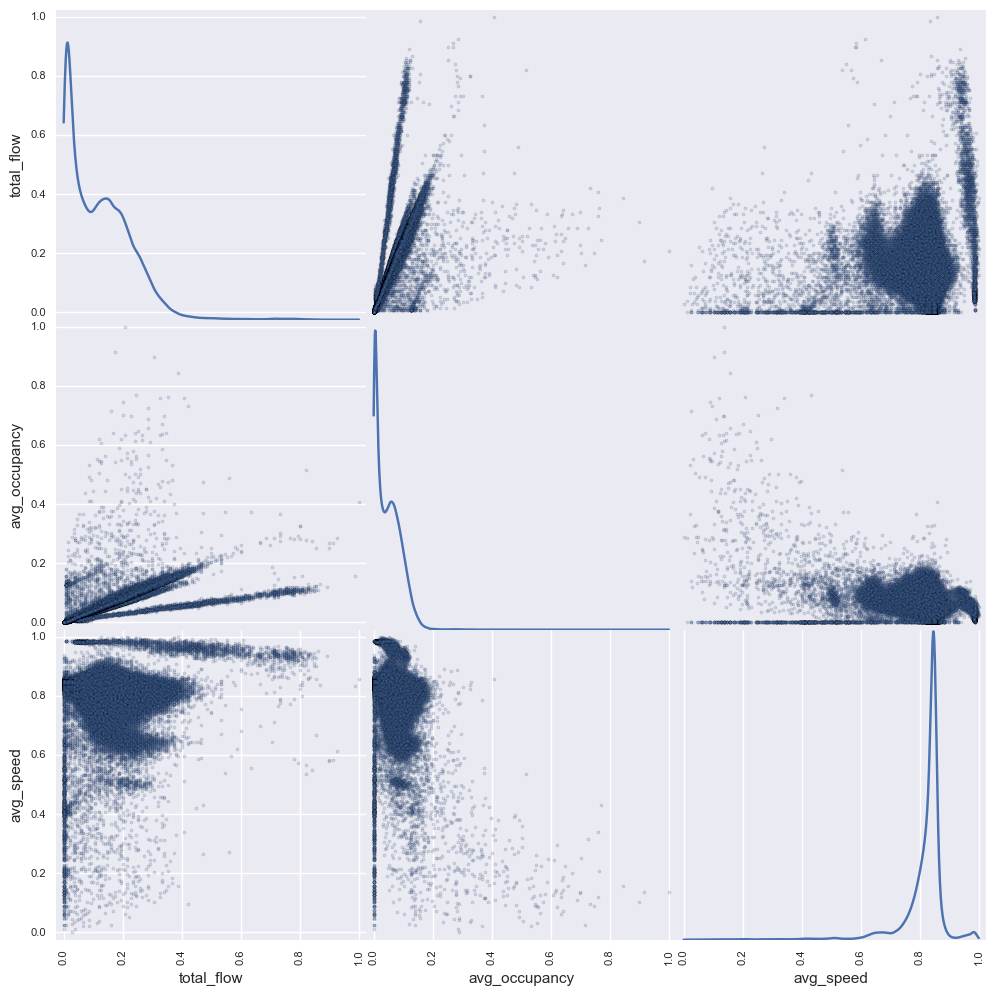

In [14]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(normalized_fsp, alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.plot()

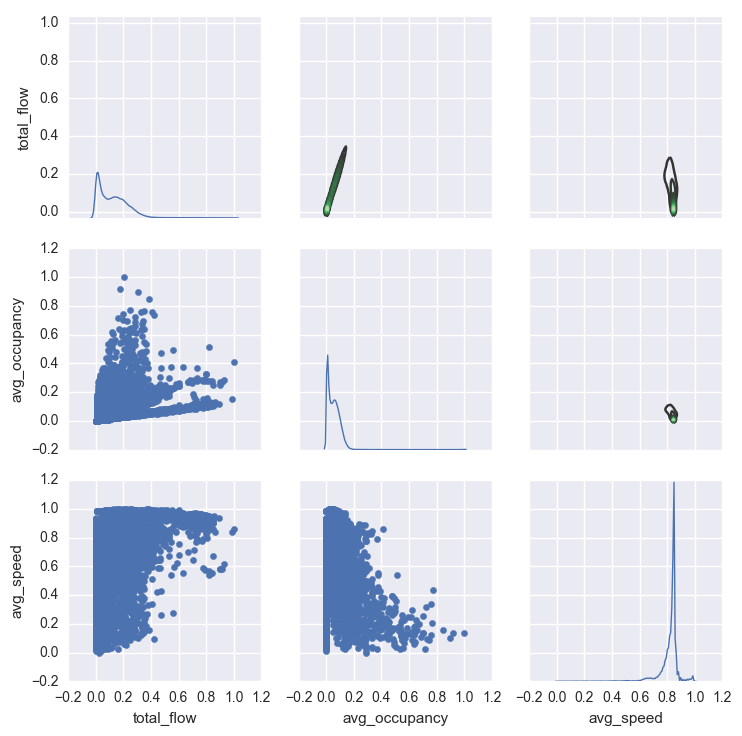

In [81]:
g = sns.PairGrid(normalized_fsp)
g.map_upper(sns.kdeplot,  n_levels=30, cmap="Greens_d")
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot, lw=1)

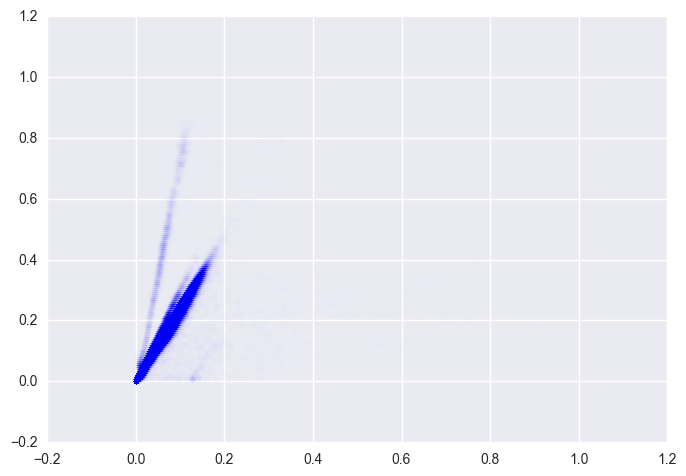

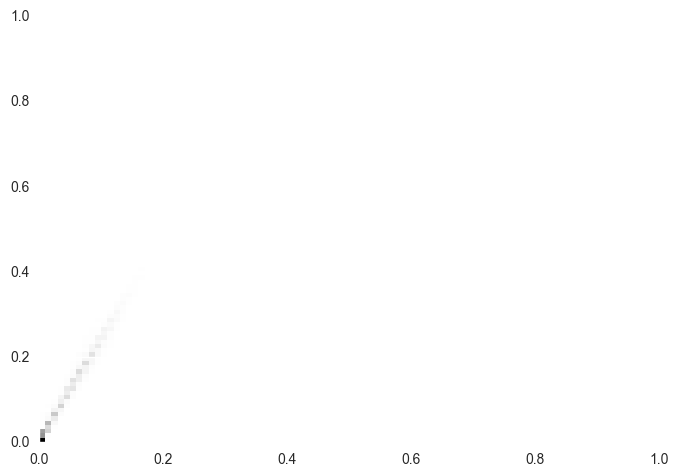

In [16]:
y = normalized_fsp.loc[:,'total_flow'].values
x = normalized_fsp.loc[:,'avg_occupancy'].values
plt.scatter(x,y,alpha=0.005)
plt.show()
plt.hist2d(x,y,bins=100);
#plt.show()

# lets try linear regression

Estimated coefficients (true, normal, RANSAC):
[[ 374.10458696]] [[ 447.9938512]]


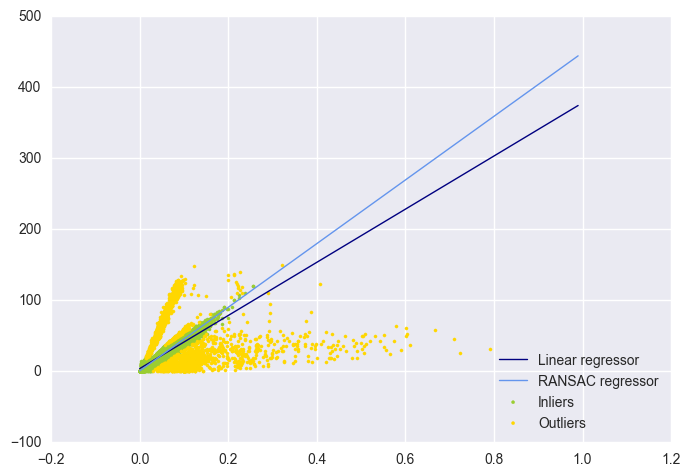

In [70]:
from sklearn import datasets, linear_model

y = fsp.loc[:,'total_flow'].to_frame()
X = fsp.loc[:,'avg_occupancy'].to_frame()


# Fit line using all data
model = linear_model.LinearRegression()
model.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X, y)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(0, 1,0.01)
line_y = model.predict(line_X[:, np.newaxis])
line_y_ransac = model_ransac.predict(line_X[:, np.newaxis])

# Compare estimated coefficients
print("Estimated coefficients (true, normal, RANSAC):")
print model.coef_, model_ransac.estimator_.coef_

lw = 1
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linestyle='-', linewidth=lw,
         label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linestyle='-',
         linewidth=lw, label='RANSAC regressor')
plt.legend(loc='lower right')
plt.show()

# Density Estimation for a Gaussian mixture

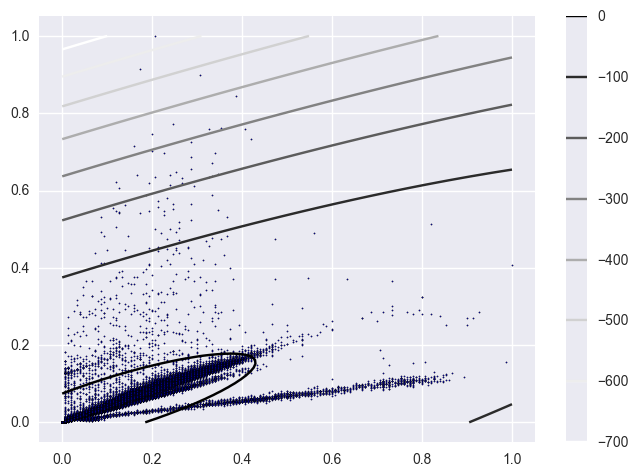

In [49]:
from matplotlib.colors import LogNorm
from sklearn import mixture

def plotit(X_train):
    # fit a Gaussian Mixture Model with two components
    clf = mixture.GaussianMixture(n_components=1, covariance_type='full')
    clf.fit(X_train)

    # display predicted scores by the model as a contour plot
    x = np.linspace(0, 1,100)
    y = np.linspace(0, 1,100)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = clf.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(X, Y, Z)
    CB = plt.colorbar(CS)
    plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    plt.axis('tight')
    plt.show()
    
plotit(normalized_fsp.loc[:,['total_flow','avg_occupancy']].values)

# What is the relationship of flow, speed and occupancy
Try to discover the relationship of flow, speed, occupancy

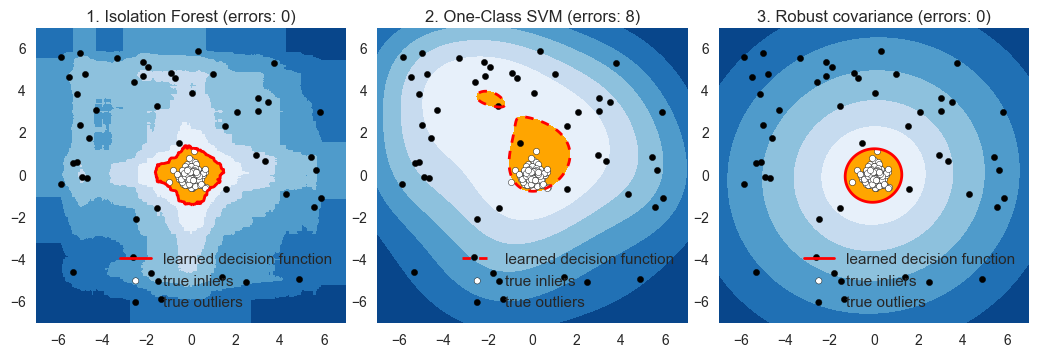

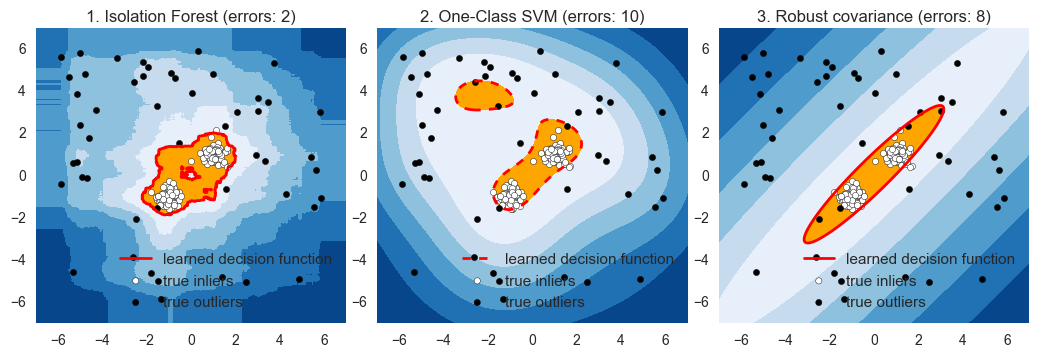

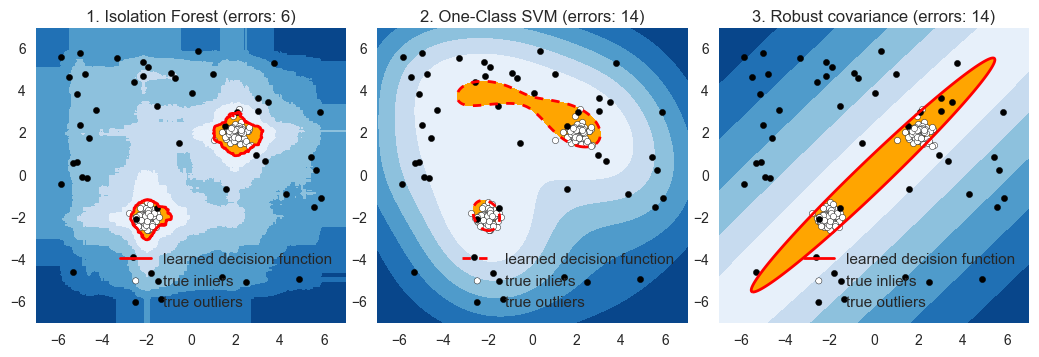

In [82]:
from scipy import stats
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(10.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()